In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [5]:
df = pd.read_excel("data/realised_schedule.xlsx")
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


pandas.tseries.holiday.USFederalHolidayCalendar

In [34]:
cal = calendar()
holidays = cal.holidays(start = df.ScheduleTime.iloc[0], end = df.ScheduleTime.iloc[-1])
print(holidays)
# df.apply({'ScheduleTime': lambda x: x.isin())})

df.ScheduleTime.isin(holidays).sum()

# np.array(holidays, dtype = str)

DatetimeIndex(['2021-01-18', '2021-02-15', '2021-05-31', '2021-06-18',
               '2021-07-05', '2021-09-06', '2021-10-11', '2021-11-11',
               '2021-11-25', '2021-12-24', '2021-12-31', '2022-01-17'],
              dtype='datetime64[ns]', freq=None)


0

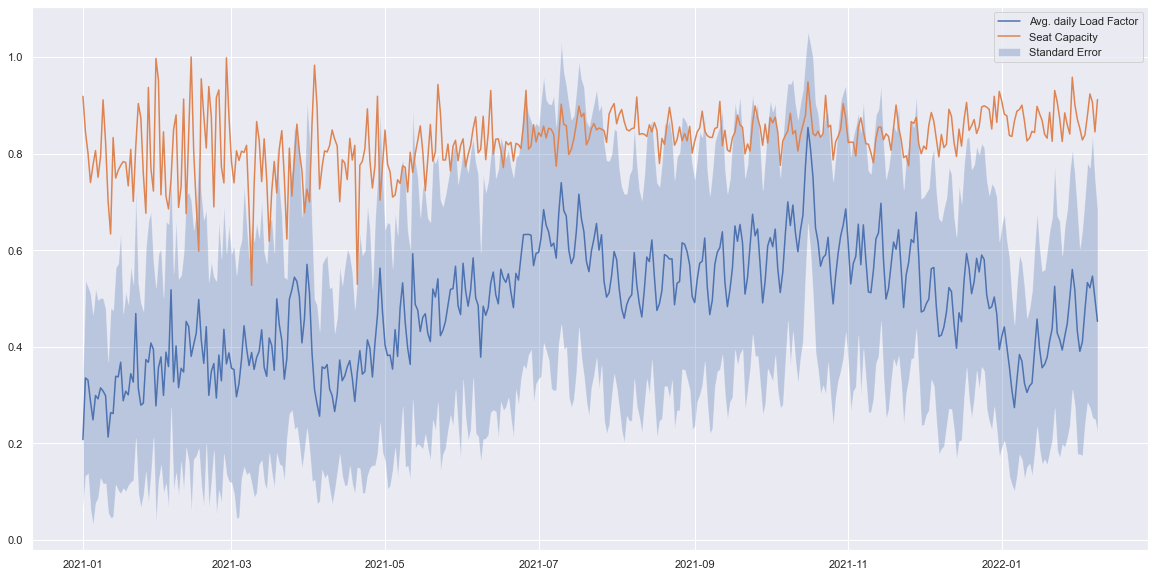

In [5]:
fig,ax = plt.subplots(figsize = (20,10))
df2 = df.set_index("ScheduleTime")
mean = df2.LoadFactor.resample('1d').mean()
mean2 = df2.SeatCapacity.resample('1d').mean() / df2.SeatCapacity.resample('1d').mean().max()
std  = df2.LoadFactor.resample('1d').std(ddof = 1)

ax.plot(mean, label = 'Avg. daily Load Factor')
ax.plot(mean2, label = 'Seat Capacity')
ax.fill_between(std.index, mean - std, mean + std, alpha = 0.3, label = 'Standard Error');
ax.legend()




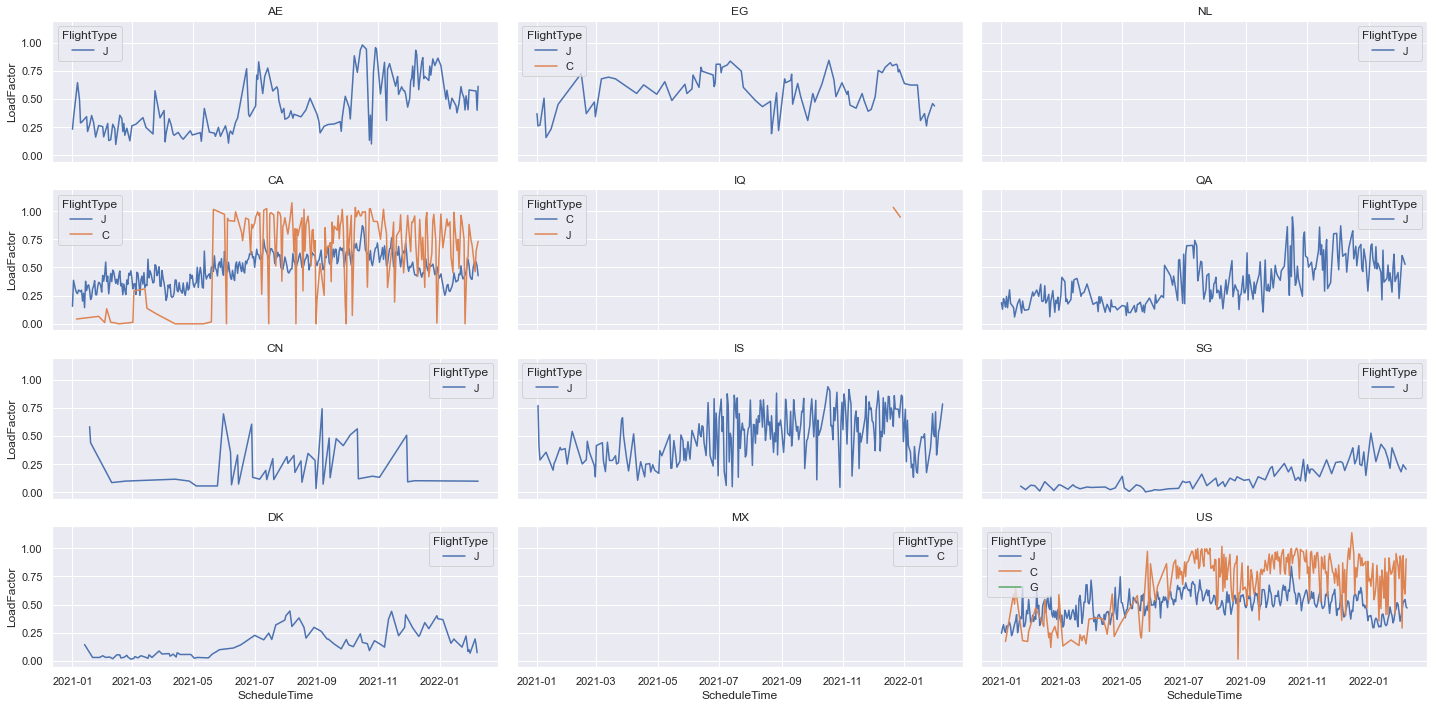

In [88]:
df2 = df.copy()
df2.ScheduleTime = pd.to_datetime(df.ScheduleTime).dt.date
df2
means = df2.groupby(["Sector", "ScheduleTime", 'FlightType']).aggregate({'LoadFactor':'mean'}).reset_index()

dests = means.Sector.unique()

fig, ax = plt.subplots(4,3, figsize = (20,10), sharey = True, sharex=True)

for i in range(len(dests)):
    
    a = ax[i % 4, i // 4]
    sns.lineplot(data = means[means.Sector == dests[i]], x = 'ScheduleTime', y = 'LoadFactor', hue = 'FlightType', legend = True, ax = a, ls = '-')
    a.set_title(dests[i])

fig.tight_layout()


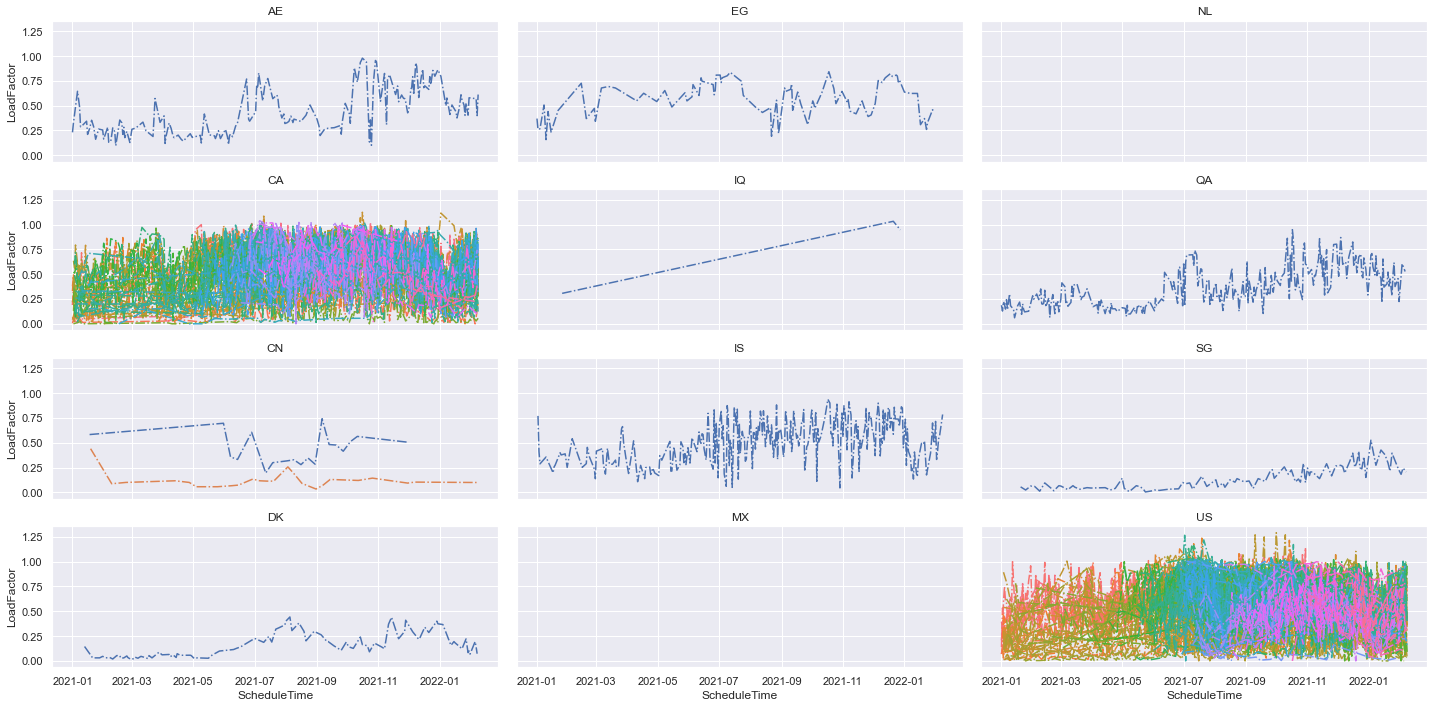

In [85]:
fig, ax = plt.subplots(4,3, figsize = (20,10), sharey = True, sharex=True)

for i in range(len(dests)):
    
    a = ax[i % 4, i // 4]
    sns.lineplot(data = means[means.Sector == dests[i]], x = 'ScheduleTime', y = 'LoadFactor', hue = 'Destination', legend = False, ax = a, ls = '-.')
    a.set_title(dests[i])

fig.tight_layout()

In [103]:
data = pd.get_dummies(df).drop(["FlightNumber", "SeatCapacity", "ScheduleTime"], axis = 1)
y = data.LoadFactor.values
X = data.drop("LoadFactor", axis = 1).values

X.shape, y.shape

((36770, 397), (36770,))

In [115]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import preprocessing as preproc # load preprocessing function

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu


K = 10
M = 20
lambdas = np.logspace(-4, 1, M)
MSE = np.zeros((K, M))

kf = KFold(n_splits=K, shuffle = True)


mse_train = np.zeros((K, M))
mse_test  = np.zeros((K,M))
betas     = np.zeros((K,M,X.shape[-1]))
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"{i} out of {K} folds")
    X_train, X_test = X[train_index, :], X[test_index, :],
    y_train, y_test = y[train_index], y[test_index]
    

    for j, lambda_ in enumerate(lambdas):
        model = linear_model.Ridge(alpha = lambda_)
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test  = model.predict(X_test)

        err_train = pow(y_train - y_hat_train, 2).mean()
        err_test = pow(y_test - y_hat_test, 2).mean()

        mse_train[i,j] = err_train
        mse_test[i,j] = err_test

        beta = model.coef_.ravel()

        betas[i,j,:] = beta

    

0 out of 10 folds
1 out of 10 folds
2 out of 10 folds
3 out of 10 folds
4 out of 10 folds
5 out of 10 folds
6 out of 10 folds
7 out of 10 folds
8 out of 10 folds
9 out of 10 folds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


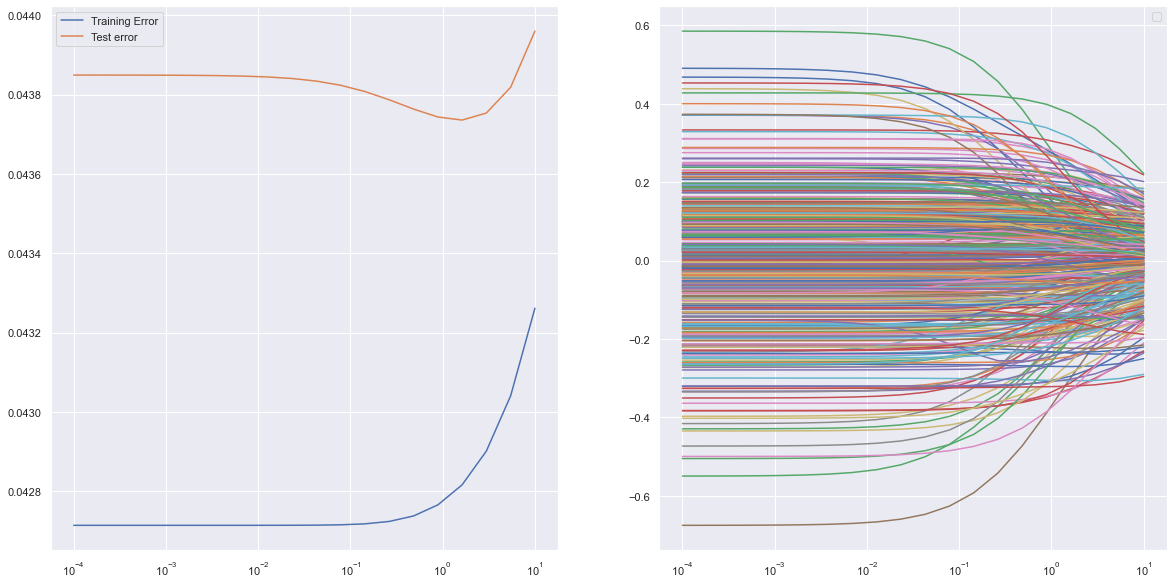

In [120]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,10))

ax[0].plot(lambdas, mse_train.mean(0), label = 'Training Error')
ax[0].plot(lambdas, mse_test.mean(0),  label = 'Test error')
ax[0].legend()
ax[0].set_xscale('log')

ax[1].plot(lambdas, betas.mean(0))
ax[1].legend()
ax[1].set_xscale('log')

In [123]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import preprocessing as preproc # load preprocessing function

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu


K = 5
M = 10
lambdas = np.logspace(-10, 1, M)
MSE = np.zeros((K, M))

kf = KFold(n_splits=K, shuffle = True)


mse_train = np.zeros((K, M))
mse_test  = np.zeros((K,M))
betas     = np.zeros((K,M,X.shape[-1]))
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"{i} out of {K} folds")
    X_train, X_test = X[train_index, :], X[test_index, :],
    y_train, y_test = y[train_index], y[test_index]
    

    for j, lambda_ in enumerate(lambdas):
        model = linear_model.Lasso(alpha = lambda_)
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test  = model.predict(X_test)

        err_train = pow(y_train - y_hat_train, 2).mean()
        err_test = pow(y_test - y_hat_test, 2).mean()

        mse_train[i,j] = err_train
        mse_test[i,j] = err_test

        beta = model.coef_.ravel()

        betas[i,j,:] = beta

    

0 out of 5 folds


c:\Users\peter\OneDrive - Danmarks Tekniske Universitet\DTU\8. Semester\02582-Computational_Data_Analysis\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.292e+02, tolerance: 2.187e-01
  model = cd_fast.enet_coordinate_descent(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


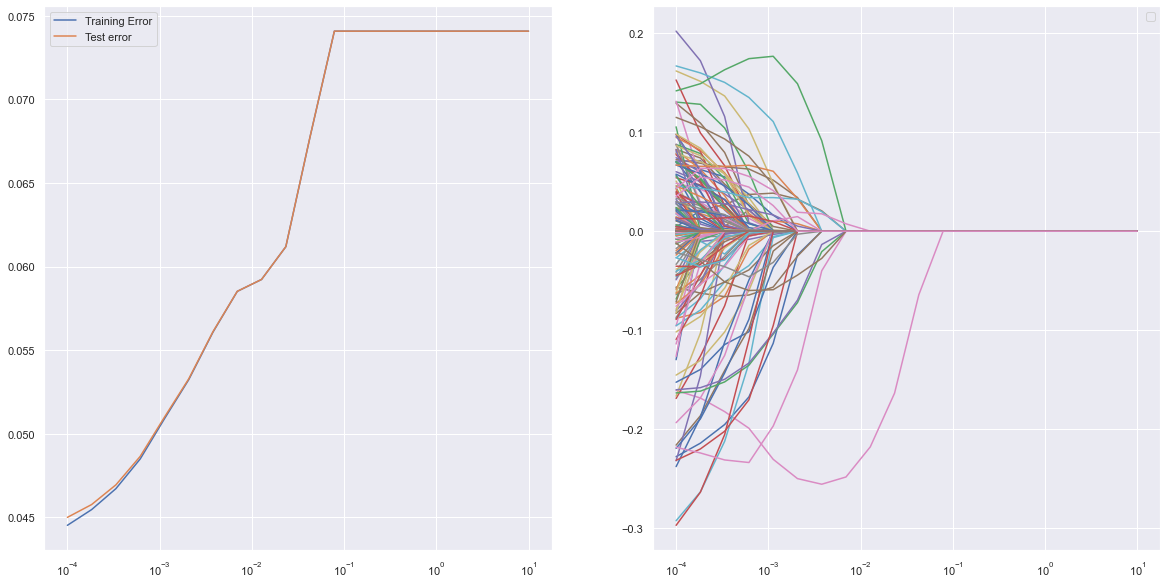

In [122]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,10))

ax[0].plot(lambdas, mse_train.mean(0), label = 'Training Error')
ax[0].plot(lambdas, mse_test.mean(0),  label = 'Test error')
ax[0].legend()
ax[0].set_xscale('log')

ax[1].plot(lambdas, betas.mean(0))
ax[1].legend()
ax[1].set_xscale('log')